# Notebook for analysis of stereotypes by genres

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange
import pickle
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

## First, we find genders of writers and directors

In [3]:
data_folder_IMDB = './IMDb data/'

In [4]:
#Importing the data
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
                     "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]

In [5]:
# To map freebase ids to imdb ids
fb_to_imdb = pd.read_csv('freebase_to_imdb.csv')
fb_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)
fb_to_imdb.head(3)

,freebaseID,IMDb_ID
0,/m/0gmgwnv,tt0443272
1,/m/03qlwpd,tt1157609
2,/m/04cvqhb,tt1161022


In [6]:
f = gzip.open(data_folder_IMDB + '/title.crew.tsv.gz', 'rb')
df_title_crew=  pd.read_csv(f, sep='\t')
df_title_crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N


In [7]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics = df_title_basics.drop(columns = ['isAdult', 'endYear', 'startYear', 'runtimeMinutes', 'titleType'])
# Getting imdb ids for freebase ids
df_movie_meta = df_movie_meta.drop(columns = ['Movie runtime', 'Movie countries', 'Movie languages', 'Movie box office revenue', 'Movie release date'])
data = df_movie_meta.merge(fb_to_imdb, how = 'inner', left_on = 'Freebase movie ID', right_on = 'freebaseID' )
# Merging cmu and imdb movies
merged_cmu_imdb = data.merge(df_title_basics, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
merged_cmu_imdb = merged_cmu_imdb.drop(columns = ['tconst', 'originalTitle', 'genres', 'freebaseID', 'primaryTitle'])

In [8]:
df_title_basics

,tconst,primaryTitle,originalTitle,genres
0,tt0000001,Carmencita,Carmencita,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,Le clown et ses chiens,"Animation,Short"
2,tt0000003,Pauvre Pierrot,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,Un bon bock,"Animation,Short"
4,tt0000005,Blacksmith Scene,Blacksmith Scene,"Comedy,Short"
...,...,...,...,...
9363385,tt9916848,Episode #3.17,Episode #3.17,"Action,Drama,Family"
9363386,tt9916850,Episode #3.19,Episode #3.19,"Action,Drama,Family"
9363387,tt9916852,Episode #3.20,Episode #3.20,"Action,Drama,Family"
9363388,tt9916856,The Wind,The Wind,Short


In [9]:
merged_cmu_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie genres,IMDb_ID
0,975900,/m/03vyhn,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333
1,28463795,/m/0crgdbh,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806
2,9363483,/m/0285_cd,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320


In [10]:
# Obtaining the crew for each movie
merged_cmu_imdb = merged_cmu_imdb.merge(df_title_crew, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
merged_cmu_imdb = merged_cmu_imdb.drop(columns = ['tconst', 'Movie genres'])

In [11]:
merged_cmu_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,nm0000118,"nm0837917,nm0000118"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,nm0803751,"nm0803751,nm0820866"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"


In [12]:
# Selecting subsets of the dataframe 
df_directors = merged_cmu_imdb[['Freebase movie ID', 'directors']]
df_directors['directors'] = df_directors['directors'].apply(lambda x : x.split(','))
df_writers = merged_cmu_imdb[['Freebase movie ID', 'writers']]
df_writers['writers'] = df_writers['writers'].apply(lambda x : x.split(','))

In [13]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
# Replacing male and female genders and keeping only them
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [14]:
# Putting only one director and writer per line
df_directors = df_directors.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
df_writers = df_writers.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
# keeping only unique directors and writers
df_writers_unique = df_writers.drop_duplicates(subset = 'writers')
df_directors_unique = df_directors.drop_duplicates(subset = 'directors')
# Getting their imdb ids
df_wri = df_writers_unique.merge(gender_imdb, how = 'inner', left_on='writers', right_on = 'IMDb_ID')
df_dir = df_directors_unique.merge(gender_imdb, how = 'inner', left_on='directors', right_on = 'IMDb_ID')

In [15]:
df_wri.head(3)

,Freebase movie ID,writers,gender,IMDb_ID
0,/m/03vyhn,nm0000118,male,nm0000118
1,/m/0crgdbh,nm0803751,male,nm0803751
2,/m/0crgdbh,nm0820866,male,nm0820866


In [16]:
gender_writers = df_wri[['writers', 'gender']]
gender_writers.head(3)

,writers,gender
0,nm0000118,male
1,nm0803751,male
2,nm0820866,male


In [17]:
df_dir.head(3)

,Freebase movie ID,directors,gender,IMDb_ID
0,/m/03vyhn,nm0000118,male,nm0000118
1,/m/0crgdbh,nm0803751,male,nm0803751
2,/m/0285_cd,nm0131910,male,nm0131910


In [18]:
gender_directors = df_dir[['directors', 'gender']]
gender_directors.head(3)

,directors,gender
0,nm0000118,male
1,nm0803751,male
2,nm0131910,male


In [19]:
gender_directors = gender_directors.drop_duplicates(subset = ['directors'])
gender_directors.directors.is_unique
gender_directors = gender_directors.set_index(['directors'])

In [20]:
gender_writers = gender_writers.drop_duplicates(subset = ['writers'])
gender_writers.writers.is_unique
gender_writers = gender_writers.set_index(['writers'])

In [21]:
gender_writers

,gender
writers,
nm0000118,male
nm0803751,male
nm0820866,male
nm0465026,female
nm0131910,male
...,...
nm0367099,male
nm0902345,male
nm0126319,male


male      24047
female     3844
Name: gender, dtype: int64


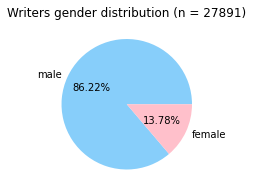

<Figure size 432x288 with 0 Axes>

In [30]:
print(df_wri['gender'].value_counts())

mylabels = ["male", "female"]
fig = plt.figure(figsize=(6,3)) 
colors = ['lightskyblue','pink']
plt.pie(df_wri['gender'].value_counts(), labels = mylabels, autopct='%1.2f%%', colors = colors)
plt.title("Writers gender distribution (n = 27891)")
plt.figure(facecolor='yellow')
plt.show()
fig.savefig('writers_gender.png', format='png', dpi=900)

male      15586
female     1658
Name: gender, dtype: int64


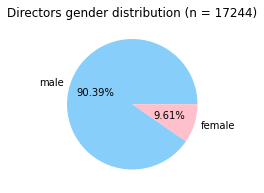

<Figure size 432x288 with 0 Axes>

In [31]:
print(df_dir['gender'].value_counts())

mylabels = ["male", "female"]
fig = plt.figure(figsize=(6,3)) 
colors = ['lightskyblue','pink']
plt.pie(df_dir['gender'].value_counts(), labels = mylabels, autopct='%1.2f%%', colors = colors)
plt.title("Directors gender distribution (n = 17244)")
plt.figure(facecolor='yellow')
plt.show()
fig.savefig('myimage.png', format='png', dpi=900)

In [184]:
merged_cmu_imdb.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,nm0000118,"nm0837917,nm0000118"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,nm0803751,"nm0803751,nm0820866"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
3,261236,/m/01mrr1,A Woman in Flames,tt0083949,nm0885554,"nm0885554,nm0959016"
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,tt0029852,nm0454771,"nm0778636,nm0873707,nm0792553,nm0000927,nm0316..."


In [185]:
merged_cmu_imdb['writers'] = merged_cmu_imdb['writers'].apply(lambda x : x.split(','))
merged_cmu_imdb['directors'] = merged_cmu_imdb['directors'].apply(lambda x : x.split(','))
merged_cmu_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]"


In [242]:
def get_gender_counts(lst, dataframe):
    # takes a list of ids as input and a table of gender linked to ids
    # returns counts of men and women in the list of ids
    male_count = 0
    female_count = 0
    unknown = 0
    if len(lst) == 0:
        return 0,0,0
    for id in lst:
        gender = dataframe[dataframe.index == id]['gender']
        if len(gender) == 1 :
            gender = gender.item()
            if gender == 'male':
                male_count += 1
            elif gender == 'female':
                female_count += 1
        else : 
            unknown += 1
    return [male_count, female_count, unknown]


In [248]:
df = merged_cmu_imdb.copy()

In [251]:
df['counts_dir'] = df['directors'].apply(lambda x: get_gender_counts(x, gender_directors))

In [249]:
df['counts_wri'] = df['writers'].apply(lambda x: get_gender_counts(x, gender_writers))

In [252]:
df

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers,counts_wri,counts_dir
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]","(1, 0, 1)","(1, 0, 0)"
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]","(2, 0, 0)","(1, 0, 0)"
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]","(2, 1, 1)","(1, 0, 0)"
3,261236,/m/01mrr1,A Woman in Flames,tt0083949,[nm0885554],"[nm0885554, nm0959016]","(1, 0, 1)","(1, 0, 0)"
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,tt0029852,[nm0454771],"[nm0778636, nm0873707, nm0792553, nm0000927, n...","(4, 1, 1)","(1, 0, 0)"
...,...,...,...,...,...,...,...,...
61939,23851782,/m/06_vb43,The Ghost Train,tt0033660,[nm0285962],"[nm0725965, nm0651357, nm0346436, nm0249218]","(4, 0, 0)","(1, 0, 0)"
61940,32468537,/m/0crwd9y,Shadow Boxing 2,tt0459759,[nm2415918],"[nm1284414, nm12760099]","(1, 0, 1)","(1, 0, 0)"
61941,34980460,/m/0g4pl34,Knuckle,tt1606259,[nm3817974],[\N],"(0, 0, 1)","(0, 0, 1)"
61942,9971909,/m/02pygw1,Another Nice Mess,tt0362411,[nm0251872],[nm0251872],"(1, 0, 0)","(1, 0, 0)"


In [253]:
df['male_writers'] = df['counts_wri'].apply(lambda x: x[0])
df['female_writers'] = df['counts_wri'].apply(lambda x: x[1])
df['unknown_writers'] = df['counts_wri'].apply(lambda x: x[2])

df['male_dir'] = df['counts_dir'].apply(lambda x: x[0])
df['female_dir'] = df['counts_dir'].apply(lambda x: x[1])
df['unknown_dir'] = df['counts_dir'].apply(lambda x: x[2])

In [255]:
df = df.drop(columns = ['counts_wri', 'counts_dir'])

In [256]:
df

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers,male_writers,female_writers,unknown_writers,male_dir,female_dir,unknown_dir
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]",1,0,1,1,0,0
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]",2,0,0,1,0,0
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]",2,1,1,1,0,0
3,261236,/m/01mrr1,A Woman in Flames,tt0083949,[nm0885554],"[nm0885554, nm0959016]",1,0,1,1,0,0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,tt0029852,[nm0454771],"[nm0778636, nm0873707, nm0792553, nm0000927, n...",4,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61939,23851782,/m/06_vb43,The Ghost Train,tt0033660,[nm0285962],"[nm0725965, nm0651357, nm0346436, nm0249218]",4,0,0,1,0,0
61940,32468537,/m/0crwd9y,Shadow Boxing 2,tt0459759,[nm2415918],"[nm1284414, nm12760099]",1,0,1,1,0,0
61941,34980460,/m/0g4pl34,Knuckle,tt1606259,[nm3817974],[\N],0,0,1,0,0,1
61942,9971909,/m/02pygw1,Another Nice Mess,tt0362411,[nm0251872],[nm0251872],1,0,0,1,0,0


In [270]:
df_with_dir_gender = df[df['male_dir'] + df['female_dir'] != 0]
len(df_with_dir_gender)

55337

In [271]:
print(len(df_with_dir_gender[df_with_dir_gender['male_dir']>df_with_dir_gender['female_dir']])/len(df_with_dir_gender))
print(len(df_with_dir_gender[df_with_dir_gender['male_dir'] == df_with_dir_gender['female_dir']])/len(df_with_dir_gender))
print(len(df_with_dir_gender[df_with_dir_gender['male_dir'] < df_with_dir_gender['female_dir']])/len(df_with_dir_gender))

0.9494009433109855
0.00607188680268175
0.04452716988633283


In [273]:
df_with_wri_gender = df[df['male_writers'] + df['female_writers'] != 0]
len(df_with_wri_gender)

50147

In [275]:
print(len(df_with_wri_gender[df_with_wri_gender['male_writers']>df_with_wri_gender['female_writers']])/len(df_with_wri_gender))
print(len(df_with_wri_gender[df_with_wri_gender['male_writers'] == df_with_wri_gender['female_writers']])/len(df_with_wri_gender))
print(len(df_with_wri_gender[df_with_wri_gender['male_writers'] < df_with_wri_gender['female_writers']])/len(df_with_wri_gender))

0.8883881388717172
0.05479889125969649
0.056812969868586354


In [277]:
df

,Wikipedia movie ID,Freebase movie ID,Movie name,IMDb_ID,directors,writers,male_writers,female_writers,unknown_writers,male_dir,female_dir,unknown_dir
0,975900,/m/03vyhn,Ghosts of Mars,tt0228333,[nm0000118],"[nm0837917, nm0000118]",1,0,1,1,0,0
1,28463795,/m/0crgdbh,Brun bitter,tt0094806,[nm0803751],"[nm0803751, nm0820866]",2,0,0,1,0,0
2,9363483,/m/0285_cd,White Of The Eye,tt0094320,[nm0131910],"[nm0465026, nm0131910, nm0458461, nm1738738]",2,1,1,1,0,0
3,261236,/m/01mrr1,A Woman in Flames,tt0083949,[nm0885554],"[nm0885554, nm0959016]",1,0,1,1,0,0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,tt0029852,[nm0454771],"[nm0778636, nm0873707, nm0792553, nm0000927, n...",4,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61939,23851782,/m/06_vb43,The Ghost Train,tt0033660,[nm0285962],"[nm0725965, nm0651357, nm0346436, nm0249218]",4,0,0,1,0,0
61940,32468537,/m/0crwd9y,Shadow Boxing 2,tt0459759,[nm2415918],"[nm1284414, nm12760099]",1,0,1,1,0,0
61941,34980460,/m/0g4pl34,Knuckle,tt1606259,[nm3817974],[\N],0,0,1,0,0,1
61942,9971909,/m/02pygw1,Another Nice Mess,tt0362411,[nm0251872],[nm0251872],1,0,0,1,0,0


In [278]:
df.to_pickle('dir_writers_genders.p')